In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import piv_fun as piv
import pof_piv as piv_old
import cv2 as cv

In [2]:
%load_ext autoreload
%autoreload 2

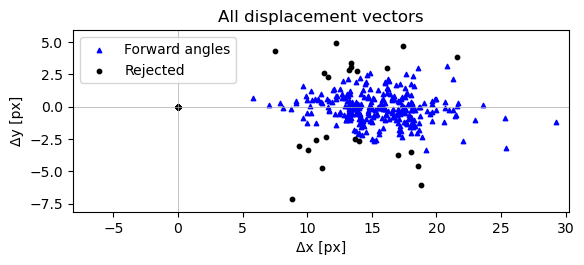

Did keep all angles due to small average displacement.


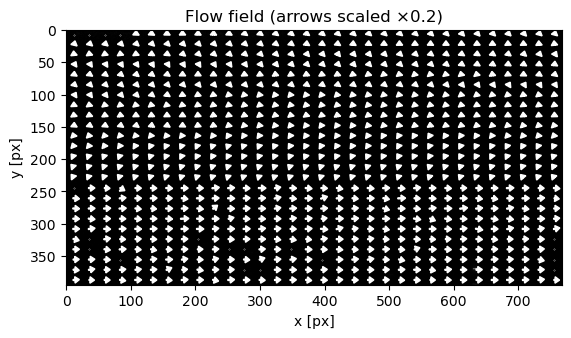

[5.90016544 5.36598143 6.23513476 5.81748846 6.08215033 5.65925444
 5.97301763 6.9347065  5.97903945 5.93987971 5.84373776 5.62727437
 6.20768343 5.95568691 5.85964119 6.41367311 5.87107706 6.47289249
 5.59026421 6.04717952 6.20188488 6.49069582 6.46750706 5.67781949
 6.2732221  6.50261585 6.59052595 6.27610447 6.75071615 6.40438819
 6.13901446 3.16448713]


In [3]:
# window_counts = (25, 8)
nr_position = 1
nr_series = 2
directory = 'piv_examples/pos' + str(nr_position) + '-' + str(nr_series) + '/'

margins = [[48, 496-443, 0, 0], 
           [60, 496-452, 0, 0],
           [10, 496-480, 0, 0],
           [0, 0, 128, 0]]
margins = margins[nr_position - 1]

frame_rate = 40000
max_shift_px = 100
hor_slices = 5
window_ct = (5, 32)
sum_rows = False
plot_flow_field = True
valid_angles = [8 * np.pi / 18, 10 * np.pi / 18]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Check whether the width of the image is divisible by the number of windows
if (images.shape[2] - margins[2] - margins[3]) % window_ct[1] != 0:
    raise ValueError('Image width is not divisible by the number of windows')

# Subtract background
background = cv.imread('data/backgrounds/pos' + str(nr_position) + '-' + str(nr_series) + '.tif',
                       cv.IMREAD_GRAYSCALE)
images = piv.subtract_background(images, background=background)

# Cut off a number of pixels in each direction given by margins
images_crop = images[:, margins[0]:(images.shape[1] - margins[1]),
         margins[2]:(images.shape[2] - margins[3])]

# In the cropped images, calculate the center of each window
window_size = (images_crop[0].shape / 
               np.array([window_ct[0] * hor_slices, window_ct[1]]))
window_y = np.arange(window_size[0]/2, images_crop[0].shape[0], window_size[0])
window_x = np.arange(window_size[1]/2, images_crop[0].shape[1], window_size[1])\
    if not sum_rows else [images_crop[0].shape[1] / 2]
window_centers = np.array([[[y, x] for x in window_x] for y in window_y]) 


## FIRST PASS
corr_init = sig.correlate(images_crop[1], images_crop[0])
hor_disp_init = piv.displacement_1d(corr_init, max_disp=max_shift_px, plot=False)

# If the correlation map has no peak, there is no need to continue
if hor_disp_init == np.nan:
    print('No movement detected')
    
# If there is movement, shift the second image to match the first
images_shift = piv.shift_displaced_image(images_crop, hor_disp_init)


# SECOND PASS
# Divide the image into slices
slice_set = np.array_split(images_shift, hor_slices, axis=1)
displacements = np.empty((window_ct[0] * hor_slices, window_ct[1], 2)) if not sum_rows else np.empty((window_ct[0] * hor_slices, 1, 2))

# Get the horizontal displacement in the slices
for j, slices in enumerate(slice_set):

    # Maximum displacement will be limited further,
    # with a minimum of 10 for peak detection purposes
    max_disp = hor_disp_init + 5 if hor_disp_init > 5 else 10
    # max_disp = max_disp
    
    # If the initial displacement was larger than 2 px, we will prevent the 
    # next search from flipping back onto the original peak at 0 movement
    ignore_only_if_mult = False if hor_disp_init > 2 else True
    
    # Calculate the displacement in the slice
    corr_slice = sig.correlate(slices[1], slices[0])
    hor_disp_slice = piv.displacement_1d(corr_slice, 
                                         ignore_disp=-hor_disp_init, 
                                         ignore_only_if_mult=ignore_only_if_mult,
                                         max_disp=max_disp,
                                         plot=False)
    
    # If this gives no result, there is no movement in this slice
    if np.isnan(hor_disp_slice):
        continue

    # Shift the second slice to match the first
    slices_shift = piv.shift_displaced_image(slices, hor_disp_slice)

    # THIRD PASS
    # Divide the slice into windows
    window_set = np.array_split(slices_shift, window_ct[0], axis=1)
    window_set = [np.array_split(row, window_ct[1], axis=2) for row in window_set]

    # For each window, calculate the correlation maps
    corr_set = [[sig.correlate(window[1], window[0]) for window in row] for row in window_set]

    if sum_rows:
        # Sum the correlation windows along the rows
        corr_set = [np.sum(row, axis=0, keepdims=True) for row in corr_set]
    
    # Again, limit the maximum displacement
    disp_set = [[piv.displacement_2d(corr, max_disp=max_disp) for corr in row] for row in corr_set]
        
    # Put the displacements in the correct place in the array
    for ji, row in enumerate(disp_set):
        for k, disp in enumerate(row):
            displacements[ji + j * window_ct[0], k] = disp + [0, hor_disp_slice + hor_disp_init]

# Plot the displacement vectors           
_,_ = piv.plot_displacements(displacements, highlight_radius_range = [1e-20, np.inf], highlight_angle_range=valid_angles, legend=['Forward angles', 'Rejected'])

# Filter out displacements within floating point precision
valid_mask = piv.filter_displacements(displacements, radius_range=[1e-20, np.inf])
displacements[~valid_mask] = np.nan

# If the average displacement is larger than 2 px, also replace displacements 
# not in the valid angle range
if np.nanmean(displacements[:, :, 0]) > 2:
    valid_mask = valid_mask & piv.filter_displacements(displacements, angle_range=valid_angles)
    displacements[~valid_mask] = np.nan
else:
    print('Did keep all angles due to small average displacement.')

# Plot flow field
_, _ = piv.plot_flow_field(displacements, window_centers, arrow_scale=0.2, arrow_color='white', background=images_crop[0])

print(np.nanmean(np.linalg.norm(displacements, axis=2), axis=0))

# TODO: test on examples also with window summing
# TODO: Maybe remove points that do not match their neighbours
